In [ ]:
import pandas as pd
from textblob import TextBlob
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

import re
import nltk
from textblob import TextBlob
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

# Descargar recursos si no están aún
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')
nltk.download('vader_lexicon')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.lda_model as lda_vis
from wordcloud import WordCloud

lemmatizer = WordNetLemmatizer()
english_vocab = set(words.words())
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# Read CSV file
df_tweets = pd.read_csv("SemEval2017-task4-dev.subtask-A.english.INPUT.csv", index_col=False)

column_names = df_tweets.columns[1:]
df_tweets = df_tweets.iloc[:, :-1]
df_tweets.columns = column_names

df_tweets = df_tweets.dropna()

df_tweets.head()

,sentiment,text
0,neutral,"""Picturehouse's, Pink Floyd's, 'Roger Waters: ..."
1,neutral,Order Go Set a Watchman in store or through ou...
2,negative,"""If these runway renovations at the airport pr..."
3,neutral,"""If you could ask an onstage interview questio..."
4,positive,A portion of book sales from our Harper Lee/Go...


## Sentiment Analysis

In [ ]:
df_tweets['sentiment'].value_counts(normalize=True) * 100

sentiment
neutral     50.126018
positive    34.213843
negative    15.660140
Name: proportion, dtype: float64

In [ ]:
def clean_text(text):
    """
    Clean and normalize text
    - Remove URLs, mentions, hastags, non-alphabetic characters
    - Convert to lowercase
    - Tokenize
    - Delete stopwords, lemmatize and filter non-existing words
    """
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"@\w+|#\w+", "", text)
    text = re.sub(r"[^a-záéíóúüñ\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()

    # Tokenize
    words_list = text.split()

    # Lemmatize and filtering stopwords + non-existing words
    cleaned = []
    for w in words_list:
        if w not in stopwords.words('english'):   # remove stopwords
            lemma = lemmatizer.lemmatize(w)
            if lemma in english_vocab:            # keep only existing words
                cleaned.append(lemma)

    return " ".join(cleaned)

# ---- Sentiment ----
def get_sentiment(text):
    """Devuelve la polaridad del texto (-1 a 1)."""
    return TextBlob(text).sentiment.polarity


def classify_sentiment_vader(score):
    if score > 0.05:
        return 'positive'
    elif score < -0.05:
        return 'negative'
    else:
        return 'neutral'

In [ ]:
df_tweets["clean_text"] = df_tweets["text"].apply(clean_text)
df_tweets["sentiment_score"] = df_tweets["clean_text"].apply(get_sentiment)
df_tweets['sentiment_pred'] = df_tweets['sentiment_score'].apply(classify_sentiment_vader)

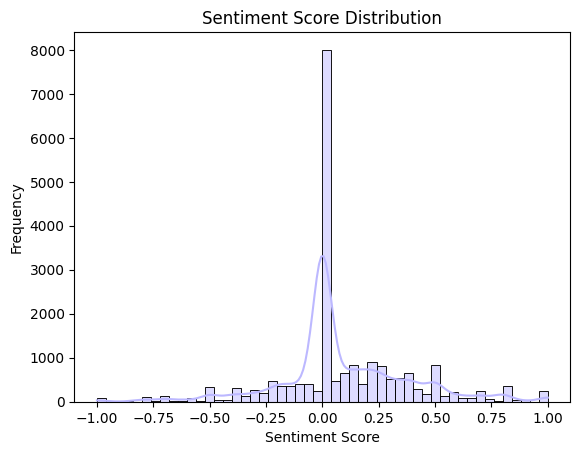

In [ ]:
sns.histplot(df_tweets["sentiment_score"], bins=50, kde=True, color='#BCB8FF')
plt.title("Sentiment Score Distribution")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

Accuracy: 0.49146956184567664

Classification Report:
              precision    recall  f1-score   support

    negative       0.29      0.32      0.30      3231
     neutral       0.59      0.49      0.53     10342
    positive       0.48      0.57      0.52      7059

    accuracy                           0.49     20632
   macro avg       0.45      0.46      0.45     20632
weighted avg       0.50      0.49      0.49     20632



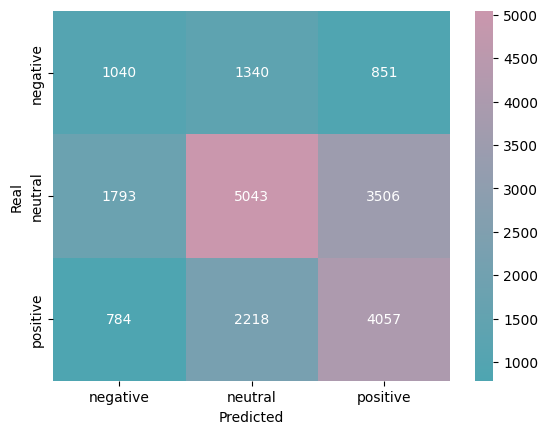

In [ ]:
y_true = df_tweets["sentiment"]
y_pred = df_tweets["sentiment_pred"]

print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

labels = sorted(list(set(y_true) | set(y_pred)))

cm = confusion_matrix(y_true, y_pred, labels=labels)

custom_cmap = LinearSegmentedColormap.from_list("my_cmap", ["#4EA5B1", "#CA97AD"])
sns.heatmap(cm, annot=True, fmt="d", cmap=custom_cmap,
            xticklabels=labels,
            yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.show()

In [ ]:
df_tweets.head(10)

,sentiment,text,clean_text,sentiment_score,sentiment_pred
0,neutral,"""Picturehouse's, Pink Floyd's, 'Roger Waters: ...",pink roger water opening sept making wave watc...,-0.100000,negative
1,neutral,Order Go Set a Watchman in store or through ou...,order go set watchman store get half price,-0.166667,negative
2,negative,"""If these runway renovations at the airport pr...",runway renovation airport prevent seeing swift...,-0.281818,negative
3,neutral,"""If you could ask an onstage interview questio...",could ask interview question miss tomorrow would,0.000000,neutral
4,positive,A portion of book sales from our Harper Lee/Go...,portion book sale harper set watchman release ...,0.800000,positive
5,positive,"""Excited to read """"Go Set a Watchman"""" on Tues...",excited read go set watchman possibly live kil...,0.255682,positive
6,positive,"""Watching Miss USA tomorrow JUST to see @Travi...",watching miss tomorrow see perform voice,0.000000,neutral
7,neutral,"""Tune-in for the 2015 MISS USA Pageant on Reel...",miss pageant p contestant,0.000000,neutral
8,positive,Call for reservations for lunch or dinner tomo...,call reservation lunch dinner tomorrow yep hap...,0.800000,positive
9,neutral,"""Miss Universe Org prez tells me #Trump won't ...",miss universe tell wont attend miss event he p...,-0.125000,negative


# Topic Modelling

In [ ]:
vectorizer = CountVectorizer(stop_words="english", max_df=0.9, min_df=5)
X = vectorizer.fit_transform(df_tweets["clean_text"])
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

terms = vectorizer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    top_terms = [terms[j] for j in topic.argsort()[-10:]]
    print(f"Topic {i+1}: {' | '.join(top_terms)}")

Topic 1: best | eagle | miss | prince | super | birthday | th | seth | world | night
Topic 2: brother | like | frank | think | want | album | dont | big | new | tomorrow
Topic 3: foo | ill | hot | fighter | concert | ticket | night | going | day | tomorrow
Topic 4: dunne | come | win | smith | sam | love | game | day | st | th
Topic 5: right | real | look | said | white | west | like | th | time | st


In [ ]:
topic_values = lda.transform(X)
df_tweets["topic"] = topic_values.argmax(axis=1)

In [ ]:
pyLDAvis.enable_notebook()

panel = lda_vis.prepare(lda, X, vectorizer)
pyLDAvis.display(panel)

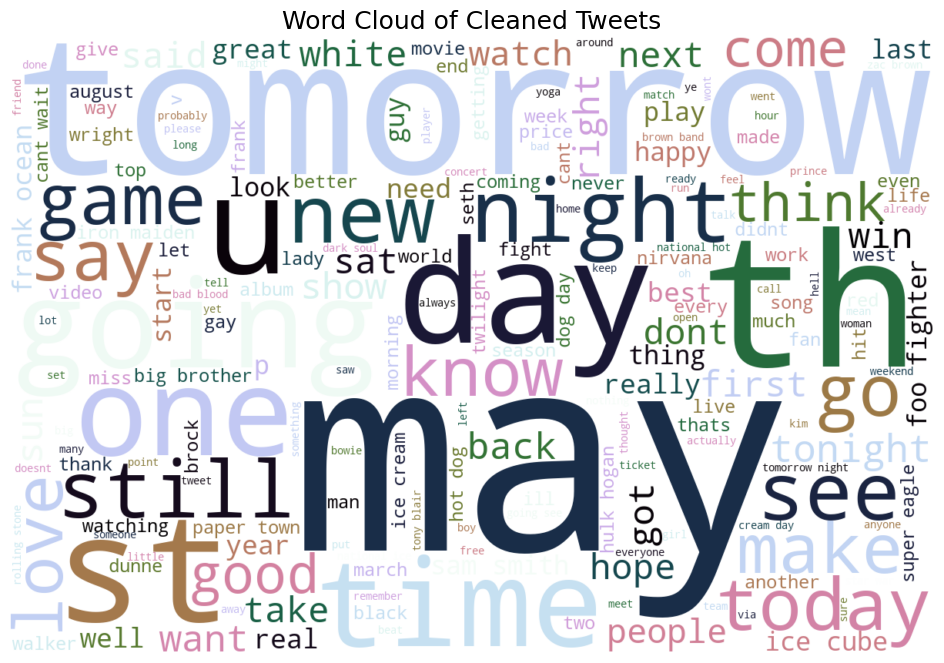

In [ ]:
text = " ".join(df_tweets["clean_text"].dropna().tolist())

# Create word Cloud
wordcloud = WordCloud(
    width=1200, height=800,
    background_color='white',
    max_words=200,
    colormap='cubehelix',
    contour_color='steelblue',
    contour_width=2,
).generate(text)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Cleaned Tweets", fontsize=18)
plt.show()
